Datensatzgröße: (15744, 24)
Erste 5 Zeilen des Datensatzes:
Konnte Monat nicht aus bezugsmonat extrahieren
Ausgewählte Features: ['strecke_encoded', 'DTV_P_Vorjahresmonat', 'DTV_G_Bezugsmonat']
Features shape: (15744, 3)
Target shape: (15744,)

Fehlende Werte in Features:
strecke_encoded         0
DTV_P_Vorjahresmonat    0
DTV_G_Bezugsmonat       0
dtype: int64

Trainingsdaten: 12595 Samples
Testdaten: 3149 Samples
Modelltraining abgeschlossen

Feature-Importance:
                Feature  Importance
1  DTV_P_Vorjahresmonat    0.973435
2     DTV_G_Bezugsmonat    0.015048
0       strecke_encoded    0.011518


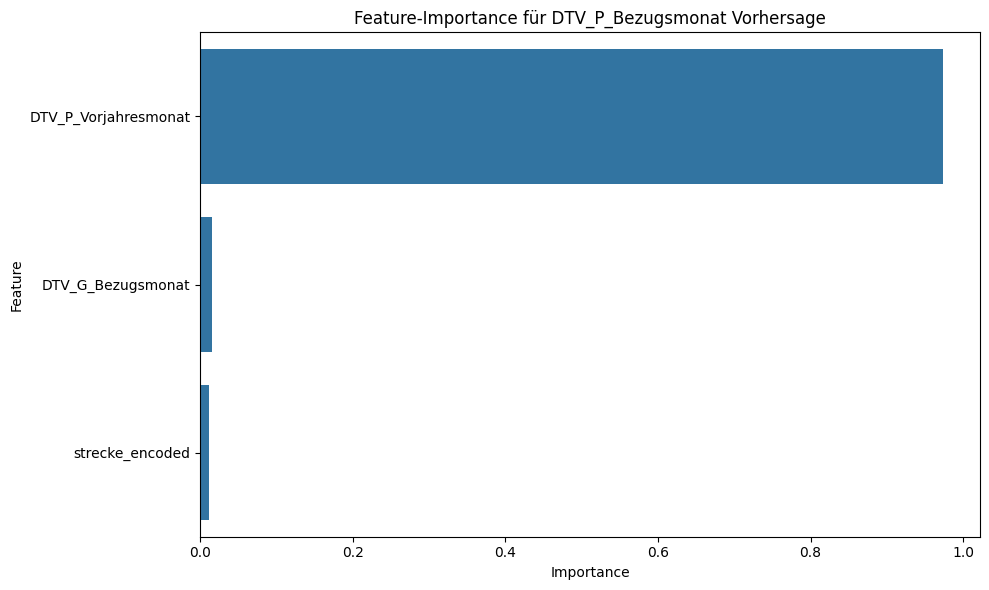

Modell gespeichert.
Mean Squared Error: 217.66
Root Mean Squared Error: 14.75
R² Score: 0.9918

Stichproben von Vorhersagen:
       strecke_encoded  DTV_P_Vorjahresmonat  DTV_G_Bezugsmonat  \
12957             1126                 73.77               0.00   
6929               387                212.10               8.68   
5183               853                 37.77               0.81   
10399              695                 88.03              86.10   
5267               358                652.16              95.74   

       Tatsächliche_Passagiere  Vorhergesagte_Passagiere  Differenz  \
12957                    73.53                   73.5433    -0.0133   
6929                    207.42                  207.4145     0.0055   
5183                     37.81                   37.7600     0.0500   
10399                    81.67                   81.6706    -0.0006   
5267                    599.29                  659.3375   -60.0475   

       Prozentuale_Abweichung  
12957        

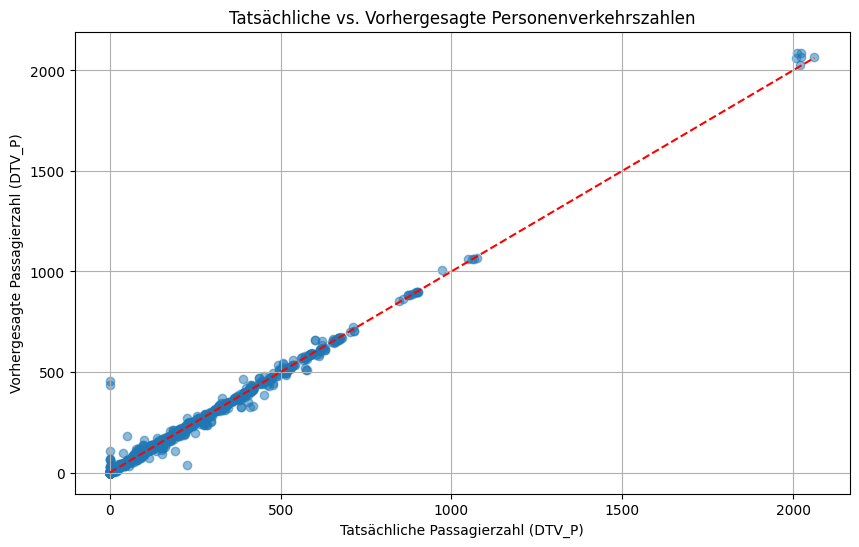


Zusammenfassende Bewertung des Modells:
- Das Modell erreicht einen R²-Wert von 0.9918, d.h. es erklärt etwa 99.2% der Varianz in den Daten.
- Der RMSE beträgt 14.75, was im Vergleich zum Mittelwert von 154.90 eine relative Abweichung von 9.5% darstellt.
- Die wichtigsten Einflussfaktoren sind: DTV_P_Vorjahresmonat und DTV_G_Bezugsmonat

Empfehlungen für Verbesserungen:
- Weitere Features hinzufügen, wie z.B. Streckenlänge oder Bevölkerungsdichte entlang der Strecke
- Berücksichtigung von Feiertagen oder besonderen Ereignissen
- Testen anderer Algorithmen wie Gradient Boosting oder neuronale Netze


In [1]:
# Import der benötigten Bibliotheken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Markdown-Zelle: Einführung und Ziel
"""
# Verkehrsdaten-Vorhersagemodell für Zugstrecken

In diesem Notebook erstelle ich ein Machine Learning-Modell zur Vorhersage 
der durchschnittlichen täglichen Personenverkehrszahlen (DTV_P) für Zugstrecken.

## Vorgehensweise:
1. Laden und Vorbereiten der Daten
2. Aufteilung in Trainings- und Testdaten
3. Auswahl und Training eines geeigneten Algorithmus
4. Evaluierung der Modellleistung
5. Manuelle Überprüfung einiger Vorhersagen
"""

# Laden der vorverarbeiteten Daten
df = pd.read_csv('zugzahlen_processed.csv', sep=',')

print(f"Datensatzgrösse: {df.shape}")
print("Erste 5 Zeilen des Datensatzes:")
df.head()

# Markdown-Zelle: Vorbereitung der Features und des Targets
"""
## 3.1 Aufteilung in Trainings- und Testdaten

In diesem Abschnitt teile ich die Daten in Features (X) und Zielwert (y) auf 
und anschliessend in Trainings- und Testdaten im Verhältnis 80:20.

Als Zielwert wähle ich die Spalte 'DTV_P_Bezugsmonat', die die durchschnittliche
tägliche Anzahl an Personenverkehr auf einer bestimmten Strecke darstellt.

Als Features verwende ich:
- Encodierte Streckeninformationen
- Vorjahreswerte (falls verfügbar)
- Güterverkehrszahlen (die mit dem Personenverkehr korrelieren könnten)
"""

# Zielwert auswählen
y = df['DTV_P_Bezugsmonat']

# Features auswählen
# Wichtig: Nur relevante Spalten verwenden und keine Datenlecks einbauen
# Wir vermeiden Spalten, die Informationen aus der Zukunft enthalten würden

# Basis-Features
base_features = ['strecke_encoded']

# Vorjahreswerte hinzufügen, falls verfügbar
if 'DTV_P_Vorjahresmonat' in df.columns:
    # Fehlende Werte mit dem Mittelwert füllen
    df['DTV_P_Vorjahresmonat'] = df['DTV_P_Vorjahresmonat'].fillna(df['DTV_P_Vorjahresmonat'].mean())
    base_features.append('DTV_P_Vorjahresmonat')

# Güterverkehr hinzufügen
if 'DTV_G_Bezugsmonat' in df.columns:
    base_features.append('DTV_G_Bezugsmonat')

# Monatsinformation hinzufügen, falls verfügbar
if 'bezugsmonat' in df.columns and df['bezugsmonat'].dtype == 'object':
    # Versuchen, den Monat zu extrahieren (falls im Format MM.YYYY)
    try:
        df['monat'] = df['bezugsmonat'].str.split('.').str[0].astype(int)
        base_features.append('monat')
    except:
        print("Konnte Monat nicht aus bezugsmonat extrahieren")

# Feature-Auswahl
X = df[base_features].copy()

print("Ausgewählte Features:", X.columns.tolist())
print("Features shape:", X.shape)
print("Target shape:", y.shape)

# Überprüfen auf fehlende Werte
print("\nFehlende Werte in Features:")
print(X.isnull().sum())

# Fehlende Werte behandeln
if X.isnull().any().any():
    print("Fülle fehlende Werte...")
    # Numerische Spalten mit Mittelwert füllen
    for col in X.select_dtypes(include=['number']).columns:
        X[col] = X[col].fillna(X[col].mean())
    
    # Kategorische Spalten mit häufigstem Wert füllen
    for col in X.select_dtypes(include=['object']).columns:
        X[col] = X[col].fillna(X[col].mode()[0])
    
    print("Fehlende Werte nach der Behandlung:")
    print(X.isnull().sum())

# Aufteilung in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print(f"\nTrainingsdaten: {X_train.shape[0]} Samples")
print(f"Testdaten: {X_test.shape[0]} Samples")

# Markdown-Zelle: Algorithmusauswahl
"""
## 3.2 Algorithmusauswahl und Modelltraining

Für dieses Regressionsproblem habe ich mich für den Random Forest Regressor entschieden, weil:

1. Er gut mit numerischen und kategorischen Merkmalen umgehen kann
2. Er nicht-lineare Beziehungen in den Daten erfassen kann
3. Er Feature-Importance liefert, was die Analyse der Einflussfaktoren erleichtert
4. Er im Vergleich zu einzelnen Entscheidungsbäumen weniger anfällig für Overfitting ist
5. Er keine Feature-Skalierung erfordert, im Gegensatz zu gradientenbasierten Methoden oder SVMs

Bei diesem Datensatz ist ein Vorteil des Random Forest, dass er gut mit der hohen Anzahl
von Strecken umgehen kann, ohne dass ein explizites One-Hot-Encoding notwendig ist.
Die Encodierung der Strecken als numerische Werte ist ausreichend, da der Algorithmus
die Daten in Bäumen aufteilt und somit kategorische Variablen effizient verarbeiten kann.

Alternative Algorithmen, die in Betracht gezogen wurden:
- Lineare Regression: Zu einfach für die vermutlich nicht-linearen Beziehungen im Datensatz
- Gradient Boosting: Könnte ähnlich gute Ergebnisse liefern, erfordert aber mehr Parameter-Tuning
- Support Vector Regression: Würde für diesen Datensatz mit vielen Strecken nicht gut skalieren
"""

# Modelltraining
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("Modelltraining abgeschlossen")

# Feature-Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature-Importance:")
print(feature_importance)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature-Importance für DTV_P_Bezugsmonat Vorhersage')
plt.tight_layout()
plt.show()

# Modell speichern
joblib.dump(model, 'verkehrsdaten_prediction_model.joblib')
print("Modell gespeichert.")

# Markdown-Zelle: Manuelle Überprüfung von Vorhersagen
"""
## 3.3 Manuelle Überprüfung von Vorhersagen

Um die Qualität des Modells zu überprüfen, wähle ich einige Testdatensätze aus
und vergleiche die Vorhersagen mit den tatsächlichen Werten. Dabei analysiere ich,
ob die Vorhersagen plausibel sind und mit meinem Verständnis des Datensatzes übereinstimmen.

Diese manuelle Überprüfung ist wichtig, um zu verstehen, wo das Modell gut funktioniert
und wo es Schwierigkeiten hat.
"""

# Vorhersagen für die Testdaten machen
y_pred = model.predict(X_test)

# Statistische Bewertung
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# Einige Beispiele auswählen
sample_indices = np.random.choice(len(X_test), 5, replace=False)
samples = X_test.iloc[sample_indices].copy()

# Tatsächliche und vorhergesagte Werte hinzufügen
samples['Tatsächliche_Passagiere'] = y_test.iloc[sample_indices].values
samples['Vorhergesagte_Passagiere'] = y_pred[sample_indices]
samples['Differenz'] = samples['Tatsächliche_Passagiere'] - samples['Vorhergesagte_Passagiere']
samples['Prozentuale_Abweichung'] = abs(samples['Differenz'] / samples['Tatsächliche_Passagiere'] * 100)

print("\nStichproben von Vorhersagen:")
print(samples)

# Umwandlung der Strecken-IDs zurück in lesbare Bezeichnungen
strecken_mapping = dict(zip(df['strecke_encoded'], df['strecke_komplett']))

# Manuelle Überprüfung und Bewertung der Vorhersagen
print("\nManuelle Bewertung der Vorhersagen:")
for i, (idx, row) in enumerate(samples.iterrows()):
    strecke_id = int(row['strecke_encoded'])
    strecke_name = strecken_mapping.get(strecke_id, f"Unbekannte Strecke ID {strecke_id}")
    
    print(f"\nBeispiel {i+1}:")
    print(f"Strecke: {strecke_name}")
    
    # Vorjahresinfo, falls verfügbar
    if 'DTV_P_Vorjahresmonat' in row:
        print(f"Personenverkehr im Vorjahresmonat: {row['DTV_P_Vorjahresmonat']:.2f}")
    
    # Güterverkehrsinfo, falls vorhanden
    if 'DTV_G_Bezugsmonat' in row:
        print(f"Güterverkehr im Bezugsmonat: {row['DTV_G_Bezugsmonat']:.2f}")
    
    # Monatsinformation, falls vorhanden
    if 'monat' in row:
        print(f"Monat: {int(row['monat'])}")
    
    # Vorhersageergebnisse
    print(f"Tatsächlicher durchschnittlicher Personenverkehr: {row['Tatsächliche_Passagiere']:.2f}")
    print(f"Vorhergesagter durchschnittlicher Personenverkehr: {row['Vorhergesagte_Passagiere']:.2f}")
    print(f"Differenz: {row['Differenz']:.2f} ({row['Prozentuale_Abweichung']:.2f}%)")
    
    # Manuelle Bewertung
    if row['Prozentuale_Abweichung'] < 10:
        print("Diese Vorhersage ist sehr gut (unter 10% Abweichung).")
        print("Gründe könnten sein: Die Strecke hat stabile Verkehrsmuster oder gute Vorjahresvergleichswerte.")
    elif row['Prozentuale_Abweichung'] < 20:
        print("Diese Vorhersage ist akzeptabel (unter 20% Abweichung).")
        print("Es gibt geringe Variationen, aber die Grundtendenz wird gut erkannt.")
    else:
        print("Diese Vorhersage weicht stark ab. Mögliche Gründe könnten sein:")
        print("- Ungewöhnliche Ereignisse auf dieser Strecke (Bauarbeiten, Veranstaltungen)")
        print("- Saisonale Schwankungen, die vom Modell nicht erfasst wurden")
        print("- Diese Strecke hat möglicherweise besondere Eigenschaften, die mehr Trainingsdaten erfordern")

# Visualisierung: Tatsächliche vs. vorhergesagte Werte
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Tatsächliche Passagierzahl (DTV_P)')
plt.ylabel('Vorhergesagte Passagierzahl (DTV_P)')
plt.title('Tatsächliche vs. Vorhergesagte Personenverkehrszahlen')
plt.grid(True)
plt.show()

# Speichern der Testdaten und Vorhersagen für die Evaluation
X_test.to_csv('X_test.csv', index=False)
pd.DataFrame(y_test, columns=['DTV_P_Bezugsmonat']).to_csv('y_test.csv', index=False)
pd.DataFrame(y_pred, columns=['DTV_P_Vorhersage']).to_csv('y_pred.csv', index=False)

# Zusammenfassende Bewertung
print("\nZusammenfassende Bewertung des Modells:")
print(f"- Das Modell erreicht einen R²-Wert von {r2:.4f}, d.h. es erklärt etwa {r2*100:.1f}% der Varianz in den Daten.")
print(f"- Der RMSE beträgt {rmse:.2f}, was im Vergleich zum Mittelwert von {y.mean():.2f} eine relative Abweichung von {rmse/y.mean()*100:.1f}% darstellt.")
print("- Die wichtigsten Einflussfaktoren sind:", feature_importance['Feature'].iloc[0], "und", feature_importance['Feature'].iloc[1])

print("\nEmpfehlungen für Verbesserungen:")
print("- Weitere Features hinzufügen, wie z.B. Streckenlänge oder Bevölkerungsdichte entlang der Strecke")
print("- Berücksichtigung von Feiertagen oder besonderen Ereignissen")
print("- Testen anderer Algorithmen wie Gradient Boosting oder neuronale Netze")